In [ ]:
#Kelvin Encarnacao text sentiment and word cloud analysis webmd reviews.

In [244]:
import pandas as pd
import numpy as np
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from textblob import TextBlob
import re
import os
import glob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import bigrams
import itertools
import collections

In [3]:
webmd = pd.read_csv('webmd.csv')

In [67]:
webmd.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,stuffy nose,9/21/2014,25dph-7.5peh,146724,5,5,i'm retired physician meds tried allergies (se...,5,male,"drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,cold symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared right even throat hurting went away ta...,5,female,"drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,ptinr go normal 2.5 100?,3,female,,0
3,75 or over,other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,falling realise,1,female,,0
4,35-44,other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,grandfather prescribed medication (coumadin) a...,1,male,,1


In [258]:
stopwords = set(stopwords.words('english'))
#preprocessing, lowercase set, removing stopwords from reviews, setting all values to strings other than ratings
for colName in ['Drug','Condition','Reviews','Sides','Sex']:
    webmd[colName] = webmd[colName].str.lower()
    if colName == 'Reviews':
        webmd[colName]=webmd[colName].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stopwords)]))

#remove stopwords from all reviews
#for review in webmd.Reviews
#merge duplicate drugs with same Ids but different string names, some duplicate row issues under different name
for drugId in set(webmd['DrugId'].tolist()):
    drugs = set(webmd[webmd['DrugId']==drugId]['Drug'].tolist())
    if len(drugs)>1:#more than one drug under same id
        merge = min(drugs, key=len)
        webmd.loc[webmd['DrugId']==drugId, 'Drug'] = merge

webmd = webmd.drop_duplicates()
webmd.Reviews = webmd.Reviews.fillna('')

In [275]:
#Set of unique conditions identified in reviews and drugs reviewed in dataset. 
conditions = set(webmd['Condition'].tolist())
drugs = set(webmd['Drug'].tolist())

In [276]:
def preprocess(text): 
    # get lowercase
    text = text.lower()
    # remove numbers  
    text = re.sub(r'\d+', '', text)
    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # strip whitespace
    text = text.strip()
    # remove stop words
    stemmer= PorterStemmer()
    tokens = word_tokenize(text)
    words = [stemmer.stem(w) for w in tokens]
    words = [w for w in words if not w in stopwords]
    text = " ".join(w for w in words)
    return text

In [283]:
#creates 4 strings representing 4 differen corpuses for types of reviews, 5-4 star, 1-2 star, 3 star, and reviews
#that had 'other' for condition field.
#4 corpuses created for later tfidf analysis and word frequency analysis based on type of review.
drugReviewsCorpus ={drug:[] for drug in drugs}
for drug in drugs:
    satisfiedReviews = preprocess(' '.join([i for i in webmd[webmd.Drug.isin([drug]) & webmd.Satisfaction.isin([4,5])].Reviews.tolist()])).replace(stemmer.stem(drug),'')
    unsatisfiedReviews = preprocess(' '.join([i for i in webmd[webmd.Drug.isin([drug]) & webmd.Satisfaction.isin([1,2])].Reviews.tolist()])).replace(stemmer.stem(drug),'')
    averageReviews = preprocess(' '.join([i for i in webmd[webmd.Drug.isin([drug]) & webmd.Satisfaction.isin([3])].Reviews.tolist()])).replace(stemmer.stem(drug),'')
    otherReviews = preprocess(' '.join([i for i in webmd[webmd.Drug.isin([drug]) & webmd.Condition.isin(['other'])].Reviews.tolist()])).replace(stemmer.stem(drug),'')
    drugReviewsCorpus[drug] += [satisfiedReviews,unsatisfiedReviews,averageReviews,otherReviews]

In [284]:
#creating dictionary with drug keys and values of lists of text corpus for different types of review to analyze
drugTermReviewFrequencies={}
vectorizer = TfidfVectorizer()
for drug in drugs:
    if len(''.join(drugReviewsCorpus[drug]))>0:#ensure there is some text
        #print(drugReviewsCorpus[drug])
        
        X = vectorizer.fit_transform(drugReviewsCorpus[drug])
        feature_names = vectorizer.get_feature_names()
        dense = X.todense()
        denselist = dense.tolist()
        df = pd.DataFrame(denselist, columns=feature_names)
        data = df.transpose()
        data.columns = ['most_satisfied','least_satisfied','averageSatisfied','other_condition']
        drugTermReviewFrequencies[drug] = data

In [262]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

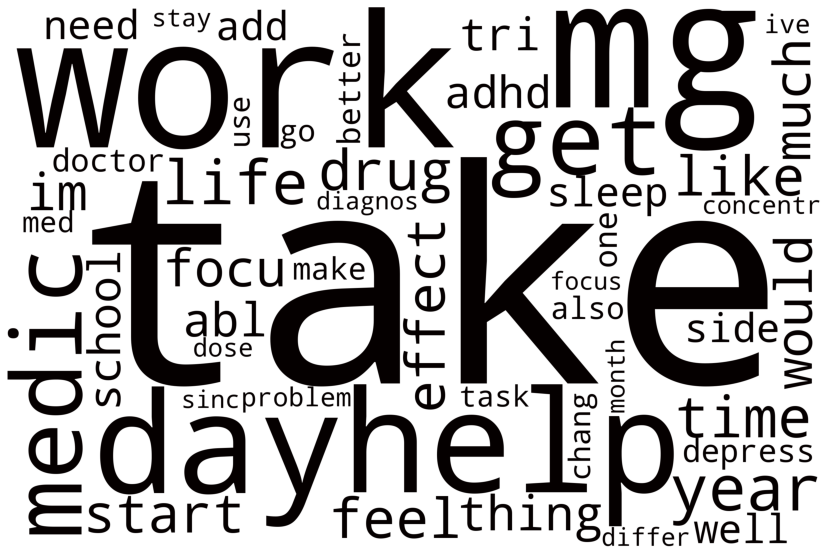

In [292]:
#word cloud for 4-5 star satisfaction reviews for adderall.
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=50).generate_from_frequencies(drugTermReviewFrequencies['adderall']['most_satisfied'])
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
plt.imshow(wordcloud)
plt.savefig('most_satisfied_adderall.png')

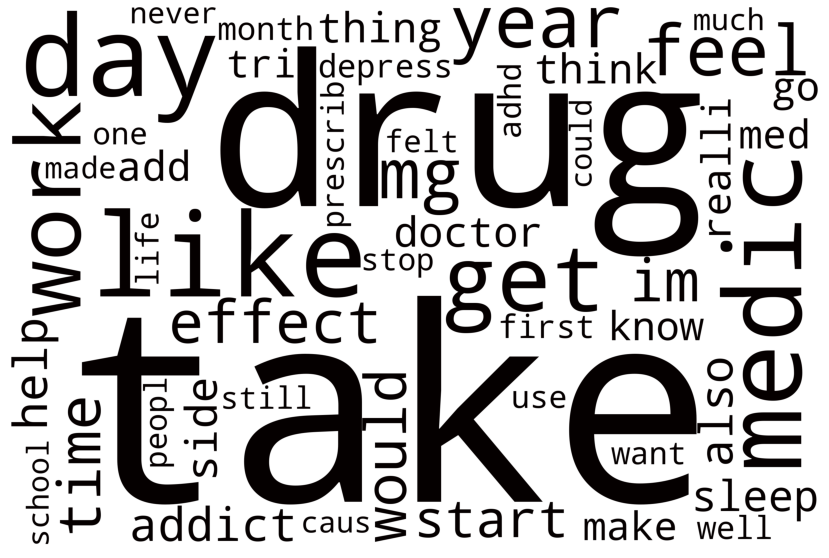

In [291]:
#word cloud for 1-2 star satisfaction reviews for adderall.
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=50).generate_from_frequencies(drugTermReviewFrequencies['adderall']['least_satisfied'])
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.imshow(wordcloud)
plt.savefig('least_satisfied_adderall.png')

In [245]:
#create dictionary storing top 20 bigrams in different reviews corpus' for every drug
from nltk import bigrams
import itertools
import collections
bigramsDict={i:[] for i in drugReviewsCorpus}
for drug in drugReviewsCorpus:
    for text in drugReviewsCorpus[drug]:
        words_in_post = [post.lower().split() for post in [text]]
        posts = [[word for word in post_words] for post_words in words_in_post]
        # Create list of lists containing bigrams in posts
        terms_bigram = [list(bigrams(post)) for post in posts]
        bigrams2 = list(itertools.chain(*terms_bigram))
        # Create counter of words in clean bigrams
        bigram_counts = collections.Counter(bigrams2)
        bigram_df = pd.DataFrame(bigram_counts.most_common(30),columns=['bigram', 'count'])
        bigramsDict[drug]+=[bigram_df]

In [290]:
bigramsDict['adderall'][0]#most satisfied reviews bigram for adderall(example)

,bigram,count
0,"(side, effect)",139
1,"(take, adderal)",110
2,"(take, mg)",78
3,"(year, old)",56
4,"(start, take)",53
5,"(feel, like)",51
6,"(chang, life)",46
7,"(work, well)",46
8,"(year, ago)",45
9,"(much, better)",42


In [249]:
bigramsDict['adderall'][1]#least satisfied reviews bigram for adderall(example)

,bigram,count
0,"(side, effect)",50
1,"(feel, like)",30
2,"(take, adderal)",28
3,"(year, old)",26
4,"(start, take)",22
5,"(take, mg)",20
6,"(stop, take)",19
7,"(take, drug)",19
8,"(take, medic)",14
9,"(adderal, xr)",14


In [356]:
def get_sentiment(post): 
    blob = TextBlob(post) 
    return blob.sentiment

In [389]:
webmd.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,stuffy nose,9/21/2014,25dph-7.5peh,146724,5,5,i'm retired physician meds tried allergies (se...,5,male,"drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,cold symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared right even throat hurting went away ta...,5,female,"drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,ptinr go normal 2.5 100?,3,female,,0
3,75 or over,other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,falling realise,1,female,,0
4,35-44,other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,grandfather prescribed medication (coumadin) a...,1,male,,1


In [382]:
#Look at total subjectivity over time and polarity over time
years = ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
data_points_yr_subjectivity = [(i,0.0) for i in years]
data_points_yr_polarity = [(i,0.0) for i in years]
for index, row in webmd.iterrows():
    subj = get_sentiment(row.Reviews).subjectivity
    pol = get_sentiment(row.Reviews).polarity
    year = row.Date.split('/')[2]
    for tup in data_points_yr_subjectivity:
        if year == tup(0):
            data_points_yr_subjectivity
    
    data_points_yr_polarity += [(year, pol)]
    data_points_yr_subjectivity += [(year, subj)]

In [390]:
easeEffective = []#ease of use and effectiveness plotted x,y for each drug in dataset
for drug in drugs:
    rowSpec = webmd[webmd['Drug']==drug]
    avgEase = sum(rowSpec.EaseofUse.tolist())/len(rowSpec)
    avgEffect = sum(rowSpec.Effectiveness.tolist())/len(rowSpec)
    easeEffective+=[(avgEase, avgEffect)]

In [393]:
len(conditions)

1806

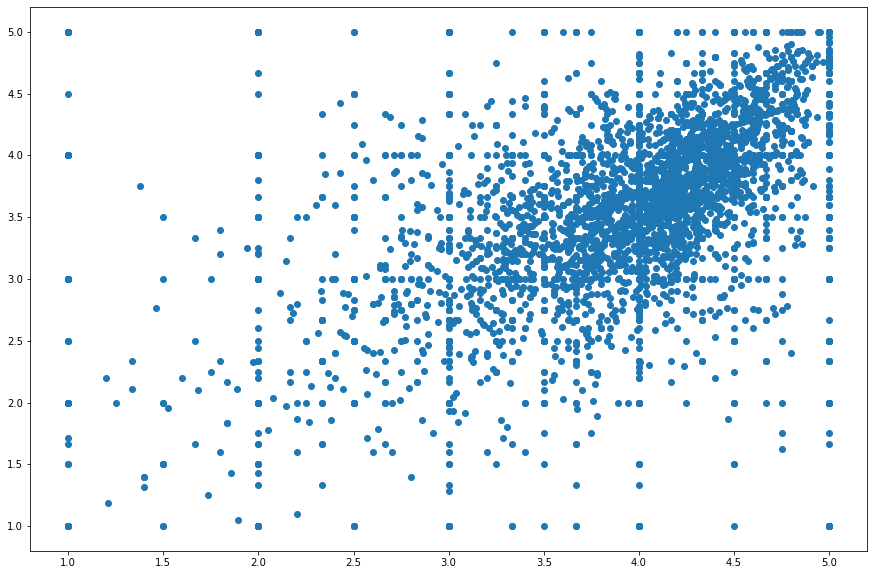

In [391]:
#for every drug plot average effectiveness vs ease of use, cool to see most common pairings
plt.figure(figsize=(15,10))
plt.scatter(*zip(*easeEffective))

In [ ]:
#look at adderall sentiment over time
#average review satisfaction over time by year
#years = set([yr.split('/')[2] for yr in webmd.Date.tolist()])
#for every year there was a review, find average satisfaction rating for all reviews in that year, plot by year
drug_yr_averages = {drug:[] for drug in drugs}
drug_yr_sentiments = {drug:[] for drug in drugs}
for drug in drug_yr_averages:
    rowSpec = webmd[webmd['Drug']==drug]
    yearList = set([yr.split('/')[2] for yr in webmd[webmd['Drug']==drug].Date.tolist()])
    #reviewsByYear = {i:j for i in yearList for j in }
    yearlySentAvg=[]
    yearlyAvgList=[]
    for year in yearList:
        rowSpec2 = rowSpec[rowSpec['Date'].str.contains(year)]
        reviews = [preprocess(i) for i in rowSpec2.Reviews.tolist()]
        avgSentiment=0
        for review in reviews:
            avgSentiment+=get_sentiment(review).polarity
            
        avgSentiment /= len(reviews)
        avg = sum(rowSpec2['Satisfaction'].tolist())/len(rowSpec2['Satisfaction'].tolist())
        yearlySentAvg+=[(year, avgSentiment)]
        yearlyAvgList+=[(year, avg)]
    drug_yr_averages[drug] += yearlyAvgList
    drug_yr_sentiments[drug] +=yearlySentAvg

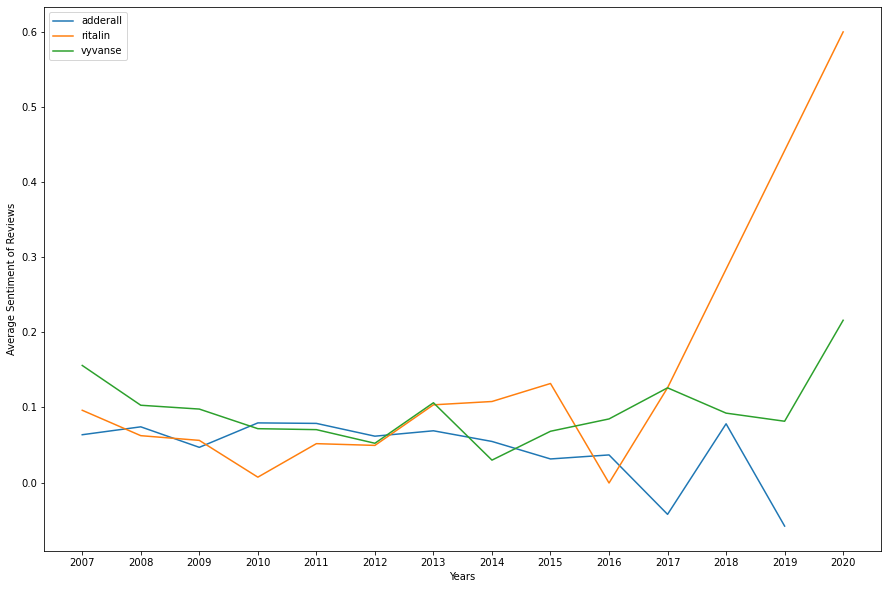

In [359]:
#compare stimulants over time SENTIMENT in ratings, compare sentiment to satisfaction
#less sentiment in ratings more analytical responses in general on drug forums.
plt.figure(figsize=(15,10))
plt.plot([x[0] for x in sorted(drug_yr_sentiments['adderall'], key=lambda tup: tup[0].polarity)],
         [x[1] for x in sorted(drug_yr_sentiments['adderall'], key=lambda tup: tup[0]polarity)], label='adderall')
plt.plot([x[0] for x in sorted(drug_yr_sentiments['ritalin'], key=lambda tup: tup[0]polarity)],
         [x[1] for x in sorted(drug_yr_sentiments['ritalin'], key=lambda tup: tup[0]polarity)], label='ritalin')
plt.plot([x[0] for x in sorted(drug_yr_sentiments['vyvanse'], key=lambda tup: tup[0]polarity)],
         [x[1] for x in sorted(drug_yr_sentiments['vyvanse'], key=lambda tup: tup[0]polarity)], label='vyvanse')
plt.legend()
plt.xlabel("Years")
plt.ylabel("Average Sentiment of Reviews")
plt.savefig('Stimulant_sentiment_time_comparison.png')
plt.show()

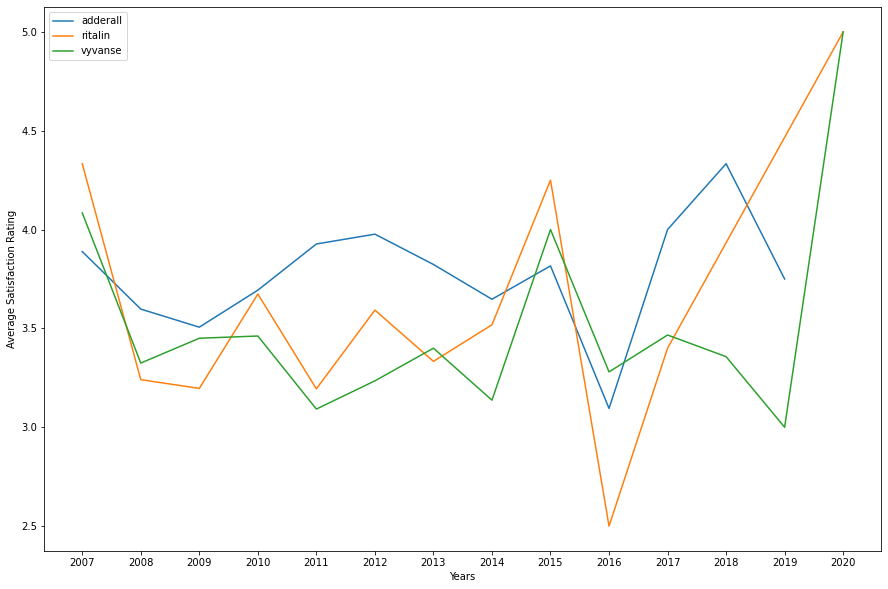

In [355]:
#compare stimulants over time satisfaction average rating for year,competitors analysis commmon stimulants over time
#by satisfaction.
plt.figure(figsize=(15,10))
plt.plot([x[0] for x in sorted(drug_yr_averages['adderall'], key=lambda tup: tup[0])],
         [x[1] for x in sorted(drug_yr_averages['adderall'], key=lambda tup: tup[0])], label='adderall')
plt.plot([x[0] for x in sorted(drug_yr_averages['ritalin'], key=lambda tup: tup[0])],
         [x[1] for x in sorted(drug_yr_averages['ritalin'], key=lambda tup: tup[0])], label='ritalin')
plt.plot([x[0] for x in sorted(drug_yr_averages['vyvanse'], key=lambda tup: tup[0])],
         [x[1] for x in sorted(drug_yr_averages['vyvanse'], key=lambda tup: tup[0])], label='vyvanse')
plt.legend()
plt.xlabel("Years")
plt.ylabel("Average Satisfaction Rating")
plt.savefig('Stimulant_satisfaction_time_comparison.png')
plt.show()

In [432]:
#list of most useful reviews to do text analytics on
most_useful = []
color_dict = {'0':'FF0000', '1':'ff6600','2':'FFCC00','3':'ccff00','4':'66ff00','5':'00FF00'}
for drug in drugs:
    rowSpec = webmd[webmd['Drug']==drug]
    if len(rowSpec)>1:#dont use skewed top reviews that are the only review
        maxUse = rowSpec.max().UsefulCount
        review = rowSpec[rowSpec.UsefulCount==maxUse].Reviews.tolist()
        sat = rowSpec[rowSpec.UsefulCount==maxUse].Satisfaction.tolist()[0]
        color = color_dict[str(sat)]
        most_useful+=[(i,color) for i in review]
useful_sentiment = [(get_sentiment(i[0]).polarity, get_sentiment(i[0]).subjectivity, i[1]) for i in most_useful]

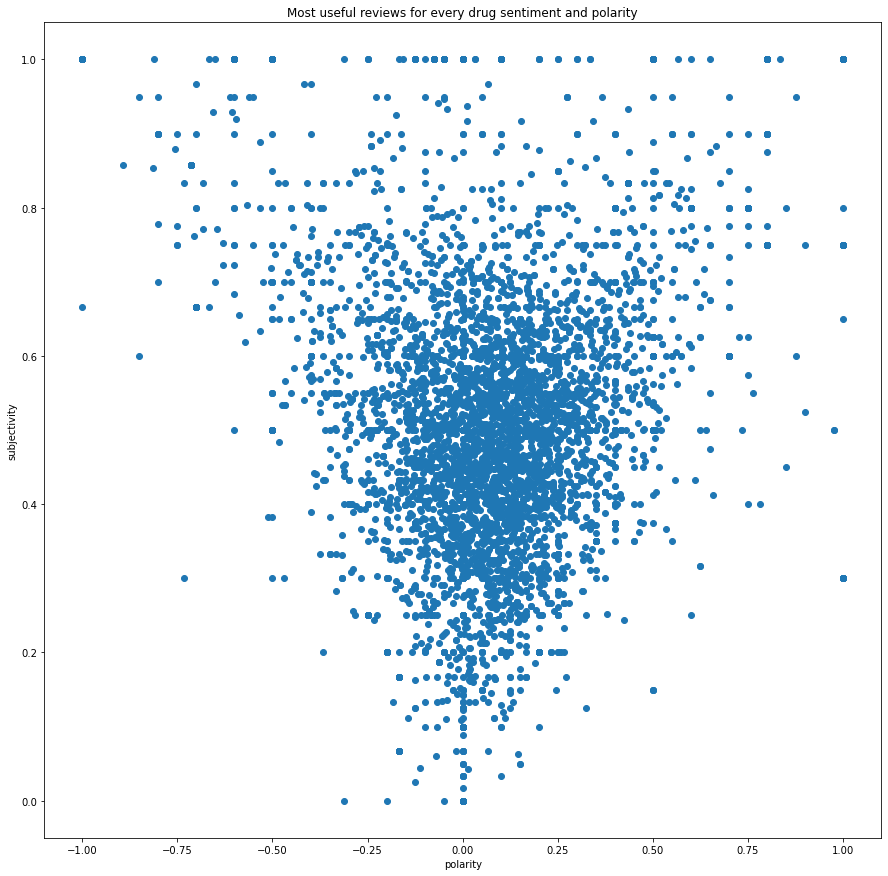

In [421]:
#Plot of all most useful(liked) reviews for every drug to see polarity and subjectivity patterns
#to characterize which reviews people find most useful.
useful_sentiment = [(get_sentiment(i).polarity, get_sentiment(i).subjectivity) for i in most_useful]
plt.figure(figsize=(15,15))
plt.xlabel("polarity")
plt.ylabel("subjectivity")
plt.title("Most useful reviews for every drug sentiment and polarity")
plt.scatter(*zip(*useful_sentiment))